# Imports

inspi.ipynb is mostly based on: https://www.kaggle.com/code/karnikakapoor/music-generation-lstm

idk why tensorflow keeps showing error - doesn't matter

In [2]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
# Get data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Loading the list of chopin's midi files as stream 
filepath = "input/numbers/chopin/" 
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = music21.converter.parse(tr)
        all_midis.append(midi)

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j) # music21.instrument
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


# Corpus

Let's not care about printing the music sheet (using lily) - we just wanna train our model for now. At some point we also want to use frequencies of music, not notes

In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['7.0', 'G3', '0.4', 'E3', '0.4.7', 'A4', '9.11', 'A4', 'G3', '5.7', '2.5', '2.5.7', 'A4', '9.0', 'A4', 'G3', '4.7', '0.4', '0.4.7', 'A4', '4.9', 'A4', 'B3', '4.7', '4.7', '4.7.11', 'C5', '0.5', 'E4', '4.9', '9.0', '9.0.4', '2', '2.6', 'E4', '9.0', 'C4', '9.0.4', '2', '5.7', 'E4', '7.11', 'B3', '4.7.11', '2', '2', '7', 'B3', '2.5', 'F3']


In [20]:
# This function is useless?? Figure out a way to remove it

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])

# Playing music

In [6]:
#to play audio or corpus - https://stackoverflow.com/questions/57021743/how-to-play-audio-inline-using-ipython-display-audio
from music21 import midi

print("Sample Audio From Data")
mf = midi.MidiFile()
mf.open('input/numbers/chopin/chp_op18.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

Sample Audio From Data


In [7]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [8]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


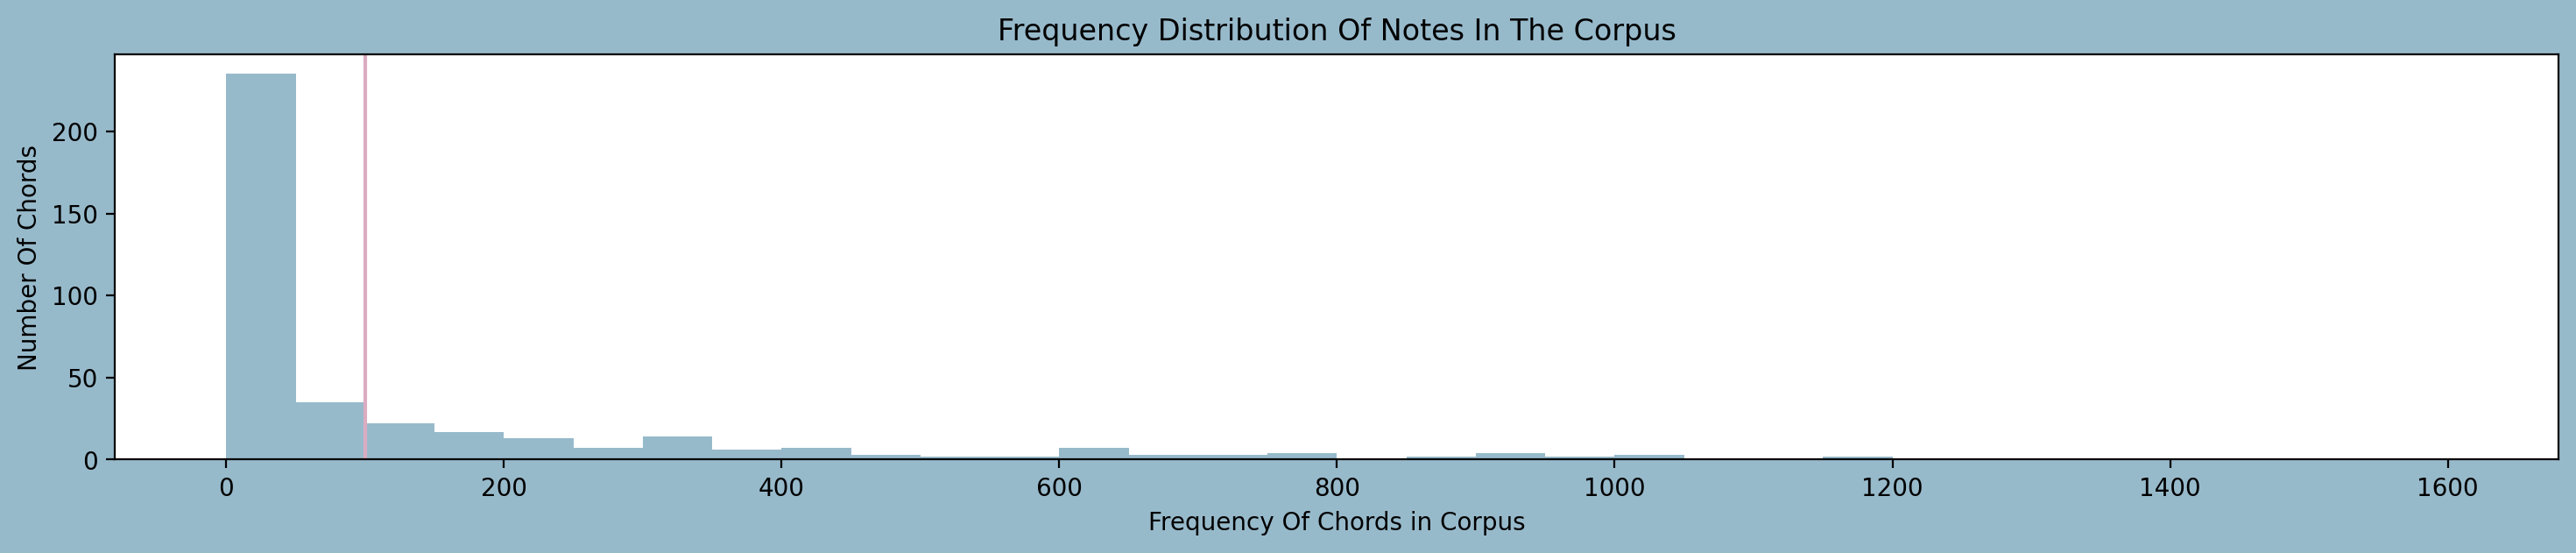

In [9]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [10]:
# Taking out the notes that were played less than 100 times.

#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [11]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53746


# Some data preprocessing

Taken from https://www.kaggle.com/code/karnikakapoor/music-generation-lstm

Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes.

In this section, I will be performing the following:

Creating a dictionary: Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

Encoding and Splitting the corpus: Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify.

Assigning X and y: The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model.

Splitting Train and Seed datasets To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

Creating a list of sorted unique characters

### Creating a list of sorted unique characters

In [12]:
# Map each unique note to a number (so our model can read it) - these will be stored in a dict.

# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53746
Number of unique characters: 255


### Encoding and Splitting the Corpus as Labels and Targets

In [13]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

#Taking out a subset of data to be used as seed (Validation, no?)
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

Total number of sequences in the Corpus: 53706


# Model - improve

In [14]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [15]:
#Model's Summary               
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 255)            │        65,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,971,455 (7.52 MB)

 Trainable params: 1,971,455 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=2) # Change number of epochs

Epoch 1/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 112s 658ms/step - loss: 4.9004
Epoch 2/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 112s 666ms/step - loss: 4.5531


[Text(0.5, 0, 'Epochs')]

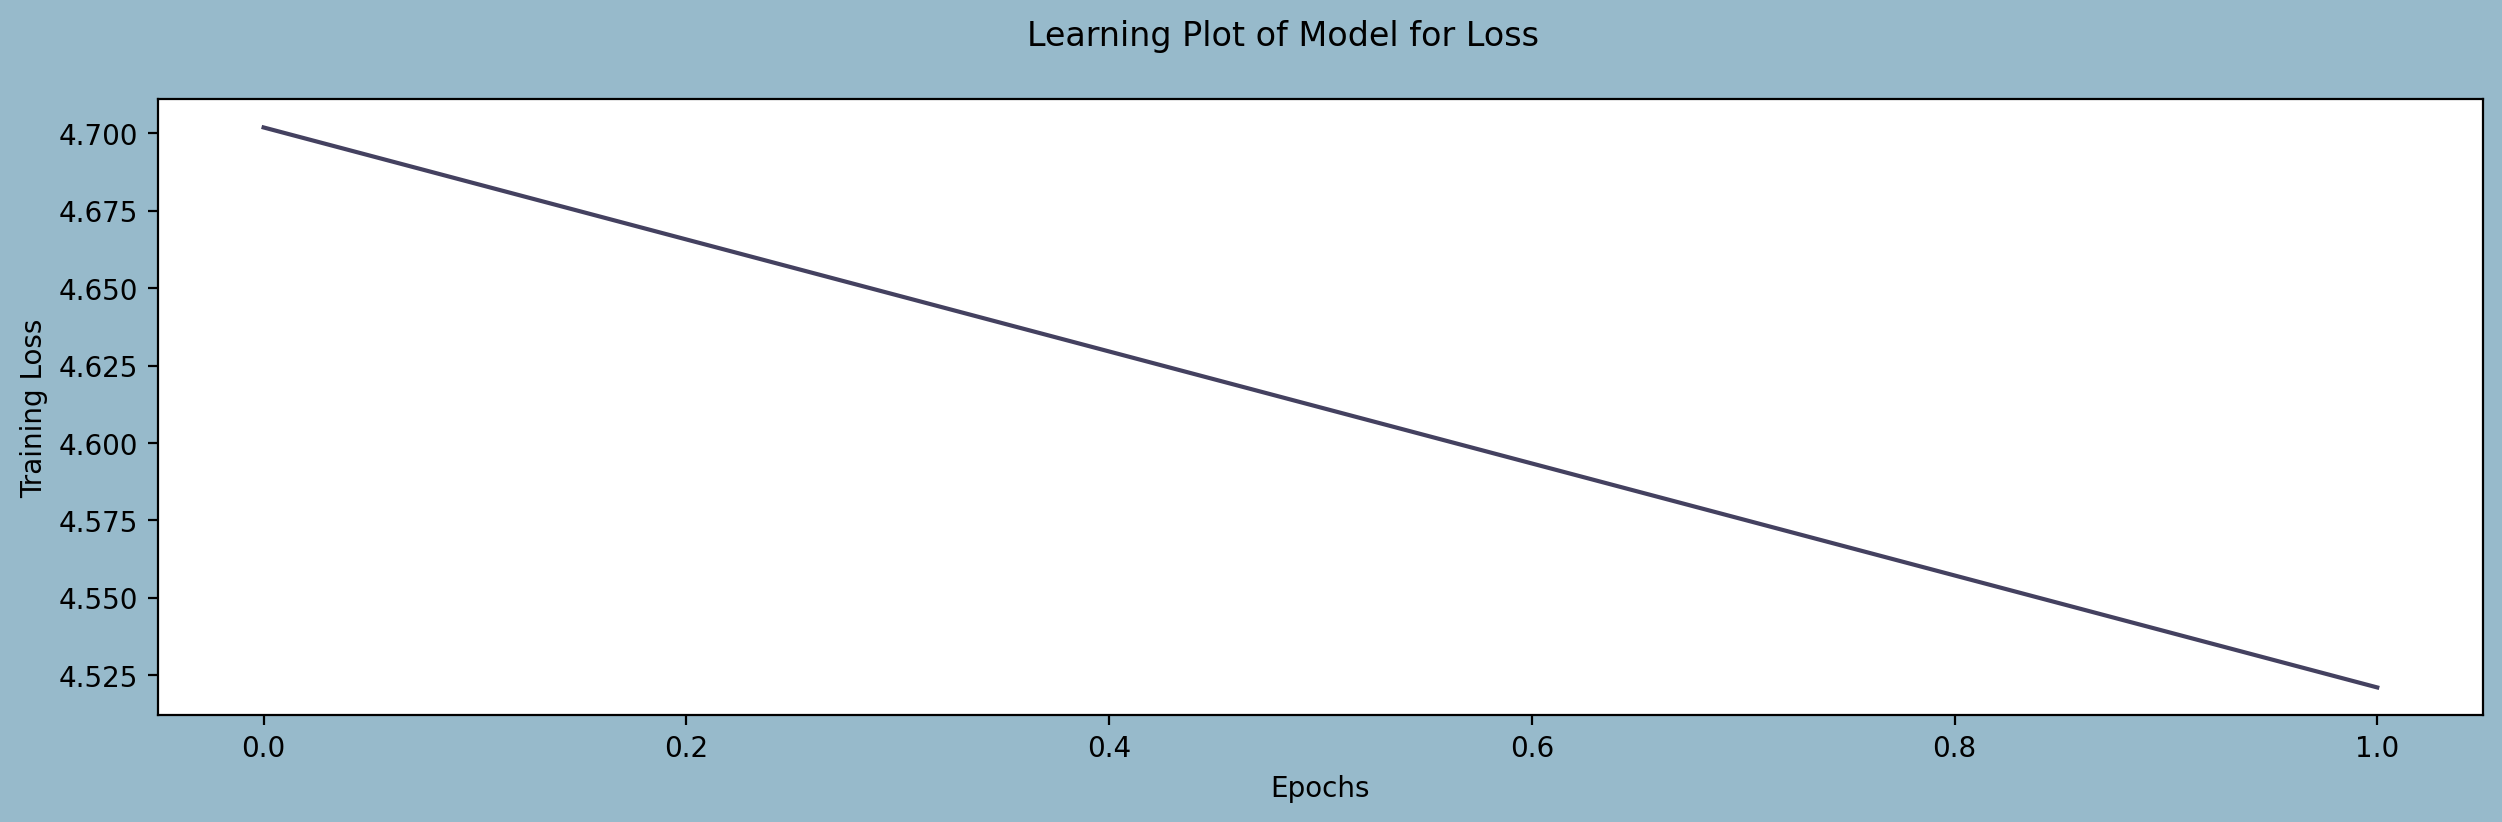

In [18]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# Getting the music

In [21]:
def music_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = music_Generator(100)
#show(Melody) # No need to show the actual nodes - we are just testing

In [22]:
# Save melody:
#fp = Melody.write('midi', fp='pathToWhereYouWantToWriteIt')

# Just play melody:
Melody.show('midi')